In [4]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
import networkx as nx


In [5]:
def generate_racks_with_labels(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates rack polygons, vertices, and storage location labels.
    Each rack is divided into 8 shelves with 10 storage locations each.
    :param rows: Number of rows of racks
    :param cols: Number of columns of racks
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks in mm
    :return: (list of rack polygons, list of vertices, dict of storage location labels)
    """
    rack_polygons = []
    vertices = []
    storage_labels = {}  # Dictionary to store storage locations per rack

    for row in range(rows):
        for col in range(cols):
            # Bottom-left corner of the rack
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a polygon for the rack
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Add vertices (corners of the rack)
            vertices.extend([
                (x_start, y_start),
                (x_start, y_start + rack_height),
                (x_start + rack_width, y_start + rack_height),
                (x_start + rack_width, y_start)
            ])

            # Generate storage labels for the rack
            rack_id = f"{row + 1:02}{col + 1:02}"
            storage_labels[rack_id] = []

            for shelf_idx, shelf_letter in enumerate("ABCDEFGH"):  # 8 shelves
                for loc_idx in range(1, 11):  # 10 locations per shelf
                    label = f"{rack_id}{shelf_letter}{loc_idx:02}"
                    storage_labels[rack_id].append(label)

    return rack_polygons, vertices, storage_labels


In [6]:
def add_picker_depot(vertices, depot_x=0, depot_y=-2000):
    """
    Adds the picker depot to the vertices.
    :param vertices: List of (x, y) vertices
    :param depot_x: X-coordinate of the depot
    :param depot_y: Y-coordinate of the depot
    :return: Updated list of vertices, depot coordinates
    """
    depot = (depot_x, depot_y)
    vertices.append(depot)
    return vertices, depot


In [7]:
def generate_adjacency_matrix(vertices, polygons):
    """
    Generates the adjacency matrix for vertices with polygons as obstacles.
    :param vertices: List of (x, y) coordinates representing vertices
    :param polygons: List of polygons representing obstacles
    :return: N-by-N binary adjacency matrix
    """
    N = len(vertices)
    adjMat = np.ones((N, N), dtype=int)  # Start with all connections allowed

    for i in range(N):
        for j in range(i + 1, N):  # Check pairs of vertices
            if i != j:
                line = LineString([vertices[i], vertices[j]])  # Line segment

                # Check if the line intersects any polygon
                for poly in polygons:
                    if line.intersects(poly):
                        adjMat[i, j] = 0  # Block the connection
                        adjMat[j, i] = 0  # Symmetry
                        break

    return adjMat


In [8]:
def generate_weighted_adjacency_matrix(vertices, adjMat):
    """
    Generates the weighted adjacency matrix based on Euclidean distance.
    :param vertices: List of (x, y) coordinates representing vertices
    :param adjMat: Adjacency matrix
    :return: N-by-N weighted adjacency matrix
    """
    N = len(vertices)
    weightedAdjMat = np.zeros((N, N))  # Initialize with zeros

    for i in range(N):
        for j in range(i + 1, N):  # Iterate through upper triangular matrix
            if adjMat[i, j] == 1:  # If connected
                # Compute Euclidean distance (L2 norm)
                distance = np.sqrt((vertices[i][0] - vertices[j][0])**2 + (vertices[i][1] - vertices[j][1])**2)
                weightedAdjMat[i, j] = distance
                weightedAdjMat[j, i] = distance  # Symmetric matrix
            else:
                # Assign a high value (∞) for disconnected vertices
                weightedAdjMat[i, j] = np.inf
                weightedAdjMat[j, i] = np.inf

    return weightedAdjMat


In [9]:
def construct_weighted_graph(vertices, weightedAdjMat):
    """
    Constructs a weighted graph using NetworkX.
    :param vertices: List of (x, y) coordinates representing vertices
    :param weightedAdjMat: Weighted adjacency matrix
    :return: NetworkX weighted graph
    """
    G = nx.Graph()  # Initialize graph

    # Add vertices
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)  # Add vertex with its position as an attribute

    # Add edges with weights
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if np.isfinite(weightedAdjMat[i, j]):  # Add edge only if weight is finite
                G.add_edge(i, j, weight=weightedAdjMat[i, j])

    return G


def visualize_weighted_graph(G, vertices, storage_labels):
    """
    Visualizes the weighted graph with vertices, edges, and storage labels.
    :param G: NetworkX graph
    :param vertices: List of vertices
    :param storage_labels: Dictionary of storage location labels
    """
    pos = nx.get_node_attributes(G, 'pos')  # Retrieve positions for nodes
    labels = {i: f"V{i}" for i in range(len(vertices))}  # Create labels for nodes
    edge_labels = nx.get_edge_attributes(G, 'weight')  # Retrieve edge weights

    # Draw the graph
    plt.figure(figsize=(15, 12))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='lightblue', node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})
    plt.title("Weighted Graph Representation")

    # Display storage labels per rack
    for rack_id, locations in storage_labels.items():
        print(f"Rack {rack_id}: {', '.join(locations[:10])} ...")  # Display first 10 storage locations for brevity

    plt.show()


Rack 0101: 0101A01, 0101A02, 0101A03, 0101A04, 0101A05, 0101A06, 0101A07, 0101A08, 0101A09, 0101A10 ...
Rack 0102: 0102A01, 0102A02, 0102A03, 0102A04, 0102A05, 0102A06, 0102A07, 0102A08, 0102A09, 0102A10 ...
Rack 0103: 0103A01, 0103A02, 0103A03, 0103A04, 0103A05, 0103A06, 0103A07, 0103A08, 0103A09, 0103A10 ...
Rack 0104: 0104A01, 0104A02, 0104A03, 0104A04, 0104A05, 0104A06, 0104A07, 0104A08, 0104A09, 0104A10 ...
Rack 0105: 0105A01, 0105A02, 0105A03, 0105A04, 0105A05, 0105A06, 0105A07, 0105A08, 0105A09, 0105A10 ...
Rack 0201: 0201A01, 0201A02, 0201A03, 0201A04, 0201A05, 0201A06, 0201A07, 0201A08, 0201A09, 0201A10 ...
Rack 0202: 0202A01, 0202A02, 0202A03, 0202A04, 0202A05, 0202A06, 0202A07, 0202A08, 0202A09, 0202A10 ...
Rack 0203: 0203A01, 0203A02, 0203A03, 0203A04, 0203A05, 0203A06, 0203A07, 0203A08, 0203A09, 0203A10 ...
Rack 0204: 0204A01, 0204A02, 0204A03, 0204A04, 0204A05, 0204A06, 0204A07, 0204A08, 0204A09, 0204A10 ...
Rack 0205: 0205A01, 0205A02, 0205A03, 0205A04, 0205A05, 0205A06,

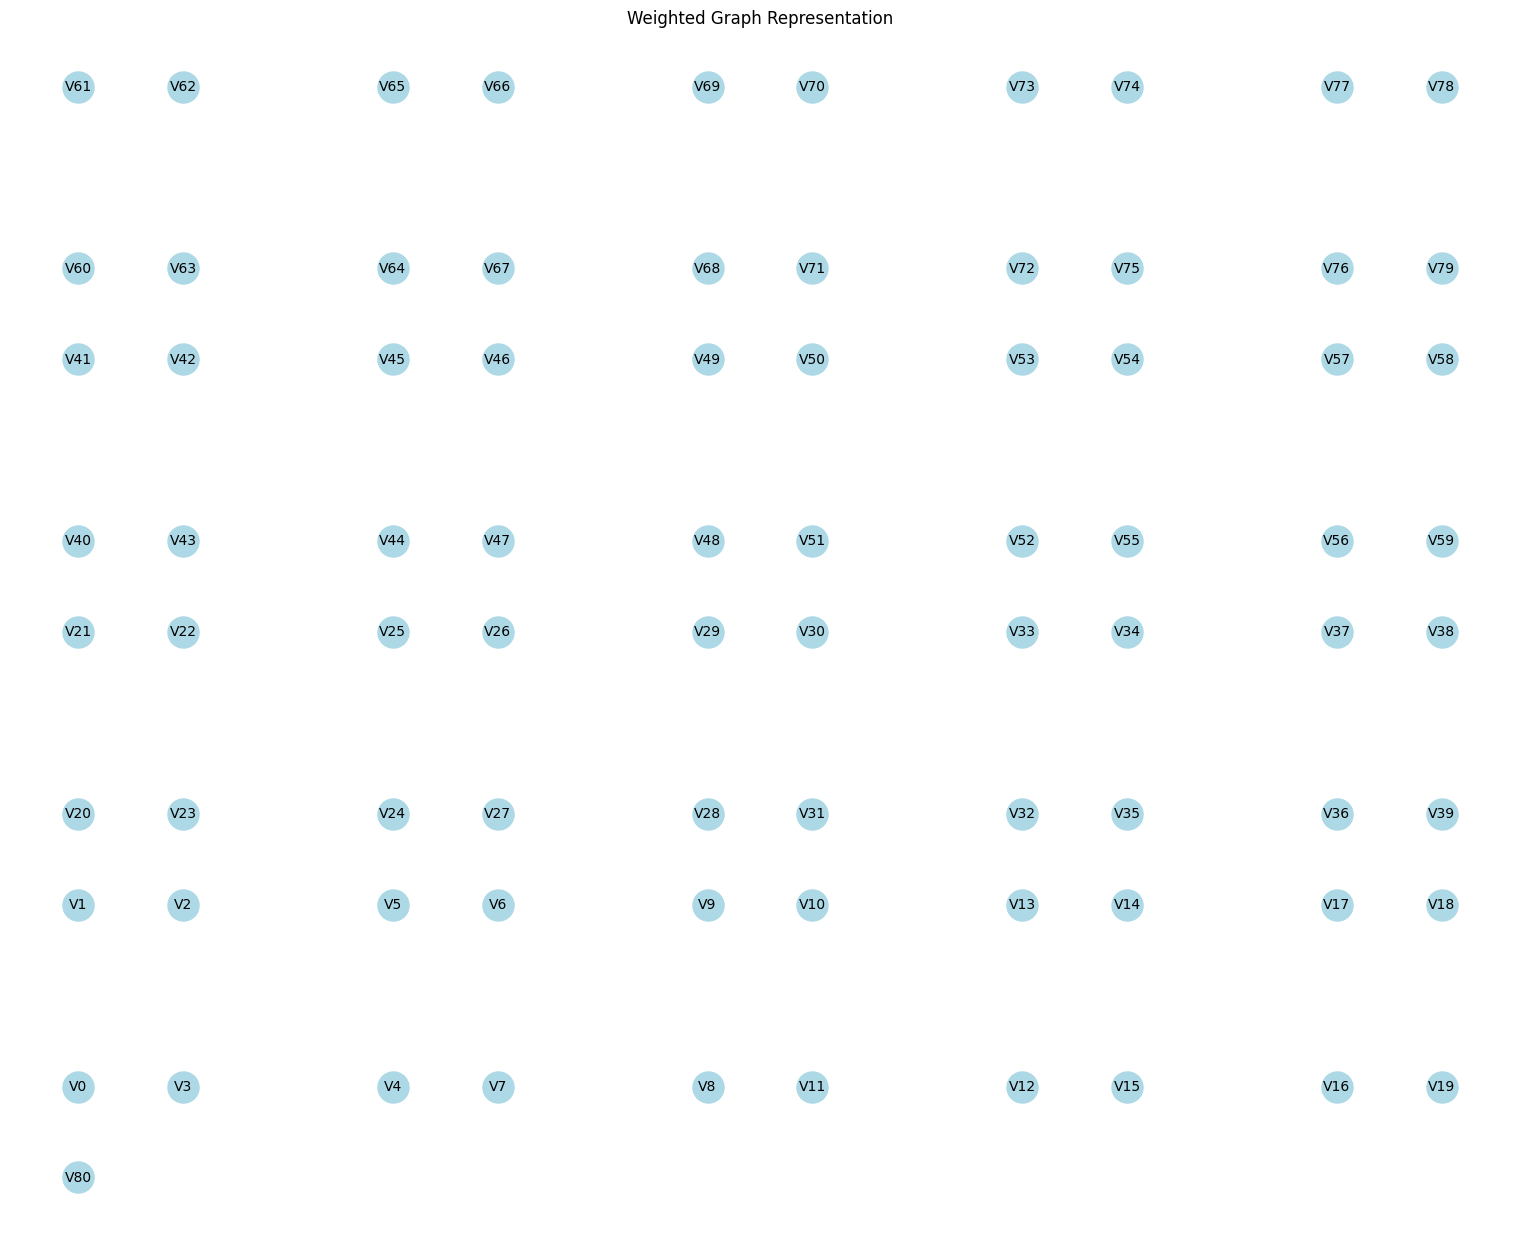

In [10]:
# Define layout parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000

# Generate rack polygons, vertices, and storage labels
rack_polygons, vertices, storage_labels = generate_racks_with_labels(rows, cols, rack_width, rack_height, walkway_width)

# Add picker depot
vertices, depot = add_picker_depot(vertices)

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, rack_polygons)

# Generate weighted adjacency matrix
weightedAdjMat = generate_weighted_adjacency_matrix(vertices, adjMat)

# Construct the weighted graph
G = construct_weighted_graph(vertices, weightedAdjMat)

# Visualize the weighted graph and storage labels
visualize_weighted_graph(G, vertices, storage_labels)
